该notebook的目的是对timestamp特征作一个平移

想法是根据空气温度的峰值进行移动：假设空气温度最高应该在下午14：00附近

事实证明平移后，rmlse从1.12降到了1.11

In [1]:
import pandas as pd
import numpy as np
#作图
import matplotlib.pyplot as plt
import seaborn as sns
#垃圾回收
import gc
#模型
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb

In [26]:
##压缩内存的函数
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
##读取天气数据
#parse_dates可以尝试将指定的列转换为日期类型
weather_train = pd.read_csv('weather_train.csv', parse_dates=['timestamp'])
weather_test = pd.read_csv('weather_test.csv', parse_dates=['timestamp'])
#合并两个天气数据
weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
#指定主键
weather_key = ['site_id', 'timestamp']
#只取三列作图
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather
gc.collect()

207

In [4]:
temp_skeleton = reduce_mem_usage(temp_skeleton)

Mem. usage decreased to  7.56 Mb (40.6% reduction)


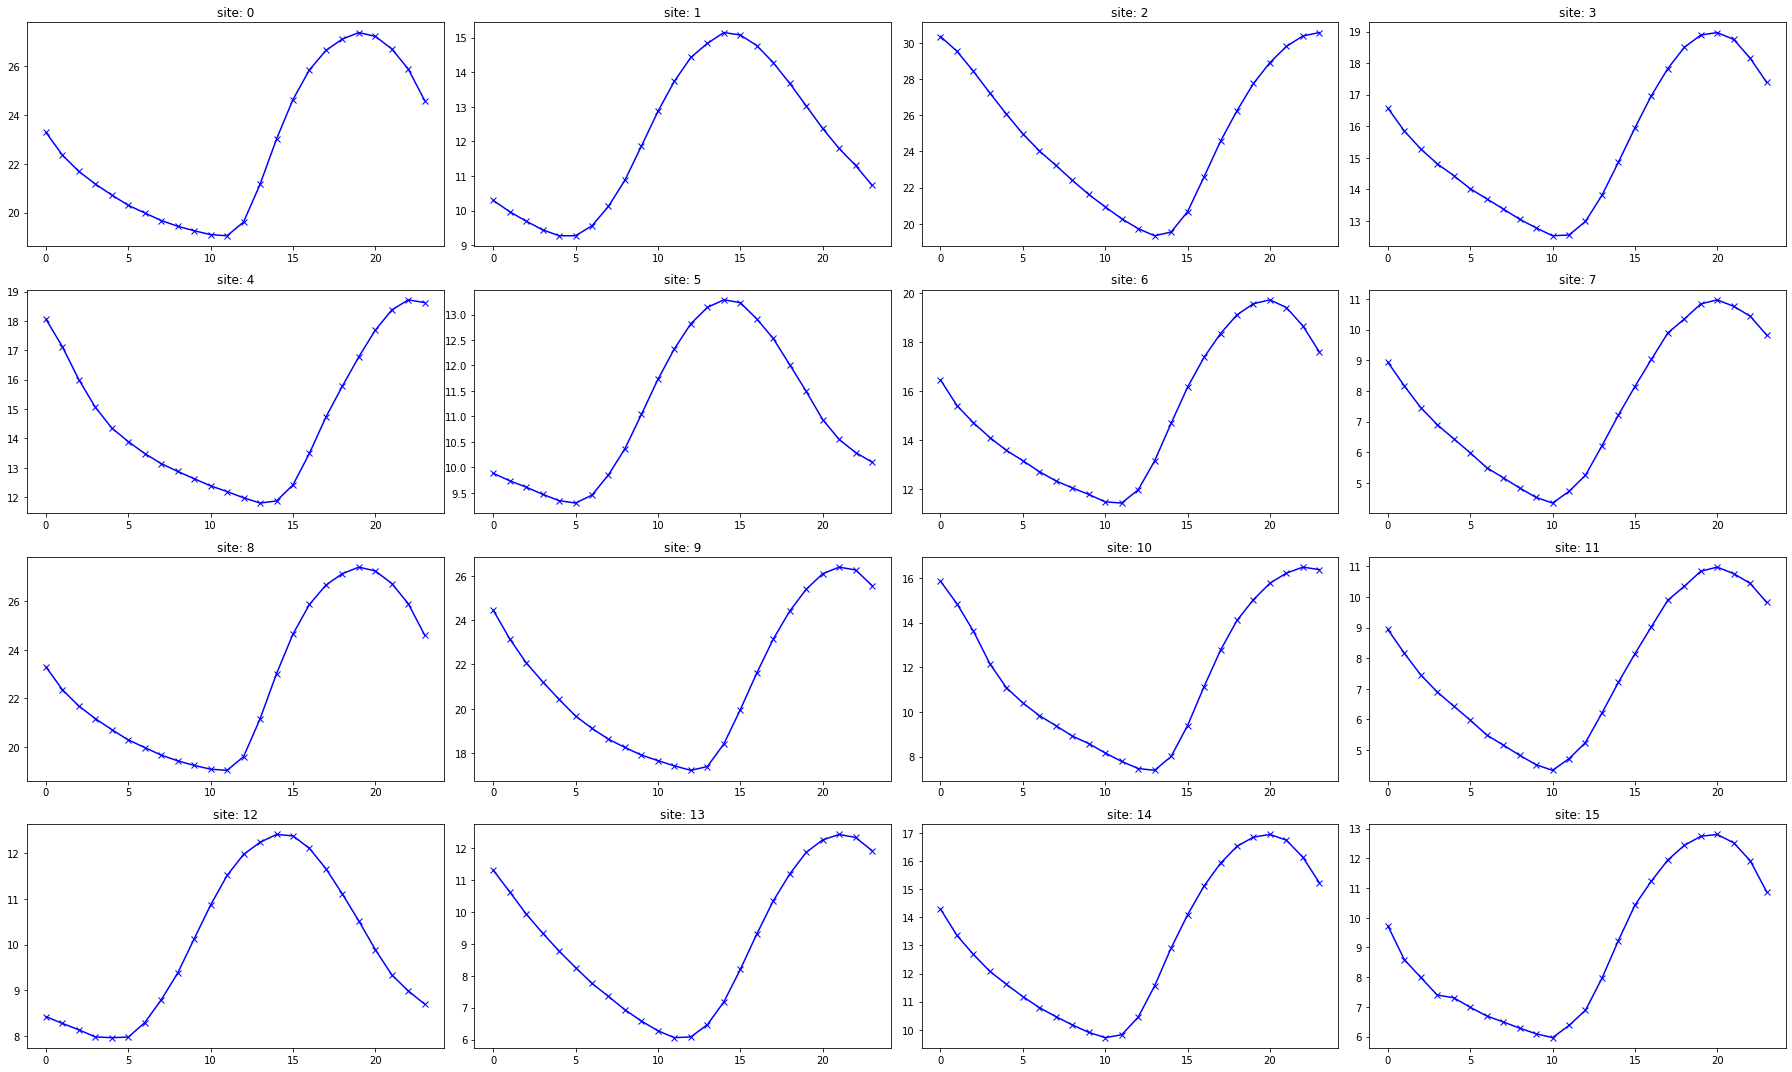

77

In [5]:
#画图
data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(25, 15))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()#自动调整子图不重叠
plt.show()
del data_to_plot
gc.collect()

发现基本上所有的温度最高点都在晚上，这让人感到奇怪

这表明可能这些timestamp并不是当地时间

In [6]:
#计算每一个site 每个小时的温度的秩
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton['timestamp'].dt.date])['air_temperature'].rank('average')

#创建一个数据框：横轴为site_id，纵轴为小时，数据为对应的秩的均值
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton['timestamp'].dt.hour])['temp_rank'].mean().unstack(level=1)

# 提取每一个site的rank最大值对应的列，求它和14的空隙
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

del temp_skeleton, df_2d
gc.collect()

#定义时间特征平移函数
def timestamp_align(df):
    df['offset'] = df['site_id'].map(site_ids_offsets)
    df['timestamp_aligned'] = (df.timestamp - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [33]:
%%time
train_df = pd.read_csv('train.csv', parse_dates=['timestamp'])
weather_train_df = pd.read_csv('weather_train.csv', parse_dates=['timestamp'])
building_meta_df = pd.read_csv('building_metadata.csv')
train_df = reduce_mem_usage(train_df)
weather_train_df = reduce_mem_usage(weather_train_df)
building_meta_df = reduce_mem_usage(building_meta_df)
gc.collect()

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Wall time: 53.8 s


215

是否需要对train也进行平移？

对目标特征meter_reading也重复上述的过程进行研究

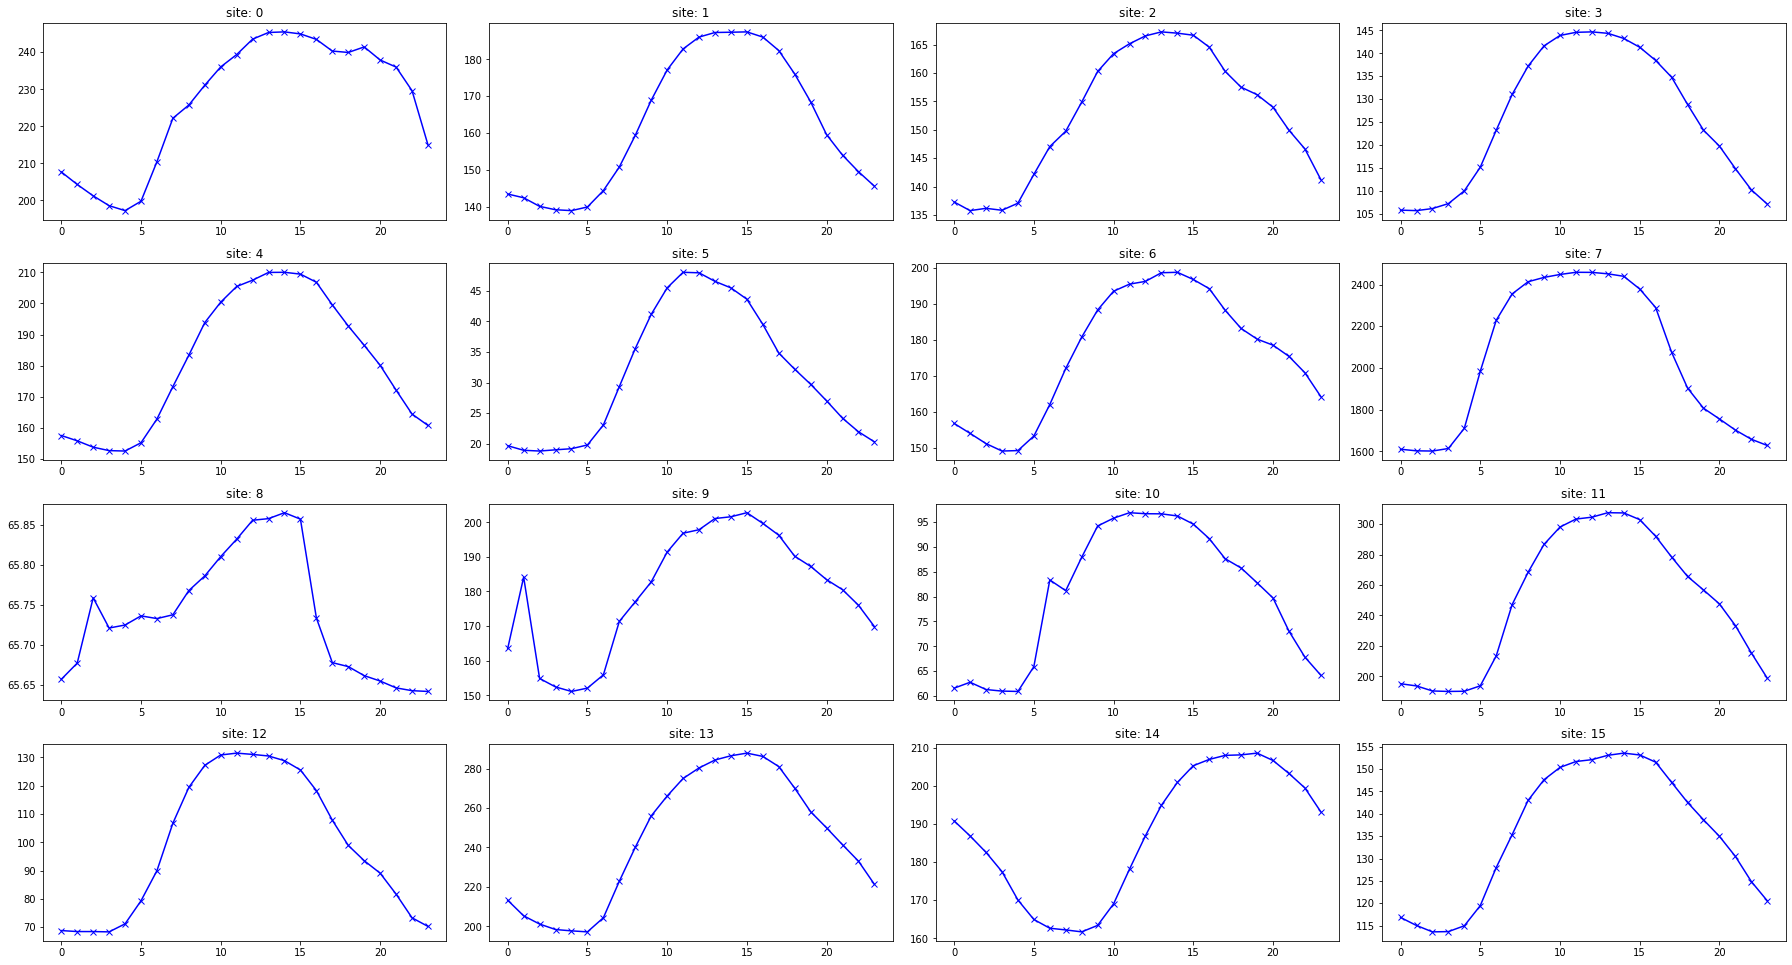

35309

In [8]:
building_site_dict = dict(zip(building_meta_df['building_id'], building_meta_df['site_id']))
site_meter_raw = train_df[['building_id', 'meter', 'timestamp', 'meter_reading']].copy()
site_meter_raw['site_id'] = site_meter_raw['building_id'].map(building_site_dict)
del site_meter_raw['building_id']
site_meter_to_plot = site_meter_raw.copy()
site_meter_to_plot["hour"] = site_meter_to_plot["timestamp"].dt.hour
elec_to_plot = site_meter_to_plot[site_meter_to_plot.meter == 0]
count = 1
plt.figure(figsize=(25, 50))
for site_id, data_by_site in elec_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean()
    ax = plt.subplot(15, 4, count)
    plt.plot(by_site_by_hour.index,by_site_by_hour['meter_reading'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del elec_to_plot, site_meter_to_plot, building_site_dict, site_meter_raw
gc.collect()

我们发现除了site14，其它地区的能耗峰值，能耗起始时间均是相似的

观察site_14会发现其能耗排名第一的是education，可能造成了和其他地区不一样的原因

In [34]:
###########数据预处理###########
#timestamp有用特征的提取
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
#增加滞后特征：这个滞后性要怎么理解？？
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]
        
train_df['date'] = train_df['timestamp'].dt.date#提取日期
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])#对数变换
#building_meta_df[building_meta_df['site_id'] == 0]
#df.query根据查询结果进行筛选
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
#??????
debug = False    
preprocess(train_df)

# https://www.kaggle.com/ryches/simple-lgbm-solution
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

weather_train_df = timestamp_align(weather_train_df)#时间特征平移
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))#插值填充

add_lag_feature(weather_train_df, window=3)#滞后特征
add_lag_feature(weather_train_df, window=72)

#作用相当于LabelEncoder
primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)#取字典对应的值？

gc.collect()

train_df = reduce_mem_usage(train_df)
building_meta_df = reduce_mem_usage(building_meta_df)
weather_train_df = reduce_mem_usage(weather_train_df)

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}
Mem. usage decreased to 890.62 Mb (39.0% reduction)
Mem. usage decreased to  0.02 Mb (36.7% reduction)
Mem. usage decreased to 18.13 Mb (4.9% reduction)


In [10]:
#类别特征
categorical_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'

numerical_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3']

In [11]:
#产生训练样本：不同meter分开训练
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[numerical_cols + categorical_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

#模型拟合
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

target_meter 0 (11714696, 34)
cat_features [31, 32, 33]
train 9371756 valid 2342940
training LGB:


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.679934	valid_1's l2: 0.719696
[40]	training's l2: 0.412436	valid_1's l2: 0.491464
[60]	training's l2: 0.355439	valid_1's l2: 0.459558
[80]	training's l2: 0.323873	valid_1's l2: 0.452217
Early stopping, best iteration is:
[79]	training's l2: 0.325059	valid_1's l2: 0.451253
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 0.3250591570615236)]), 'valid_1': OrderedDict([('l2', 0.4512531117531285)])})
train 9371757 valid 2342939
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 0.706793	valid_1's l2: 0.639733
[40]	training's l2: 0.441619	valid_1's l2: 0.375367
[60]	training's l2: 0.381697	valid_1's l2: 0.327435
[80]	training's l2: 0.352131	valid_1's l2: 0.314683
[100]	training's l2: 0.321255	valid_1's l2: 0.311324
Early stopping, best iteration is:
[97]	training's l2: 0.32676	valid_1's l2: 0.310667
best_score defaultdict(<c

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Wall time: 28min 8s


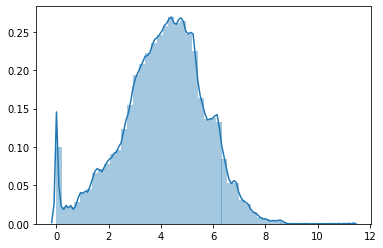

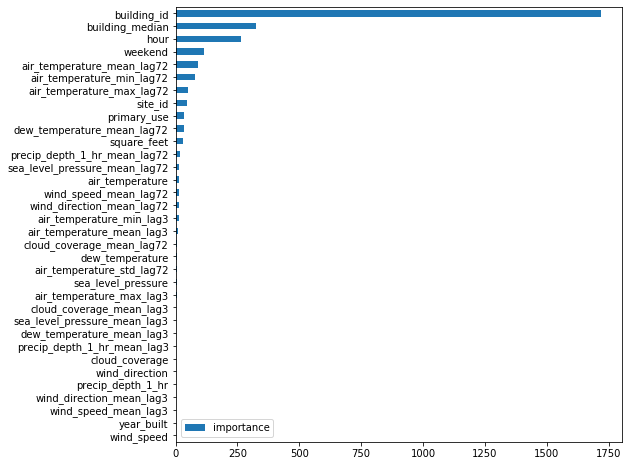

In [12]:
%%time
#meter=0

target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in categorical_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=categorical_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

#查看模型系数
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=numerical_cols + categorical_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

#plot_feature_importance(models0[1])

target_meter 1 (4182440, 34)
cat_features [31, 32, 33]
train 3345952 valid 836488
training LGB:


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.39444	valid_1's l2: 2.78748
[40]	training's l2: 1.69997	valid_1's l2: 1.92607
[60]	training's l2: 1.46114	valid_1's l2: 1.74801
[80]	training's l2: 1.34216	valid_1's l2: 1.69785
[100]	training's l2: 1.26171	valid_1's l2: 1.67589
[120]	training's l2: 1.19631	valid_1's l2: 1.66786
[140]	training's l2: 1.15154	valid_1's l2: 1.66548
[160]	training's l2: 1.10891	valid_1's l2: 1.66451
[180]	training's l2: 1.07833	valid_1's l2: 1.6598
[200]	training's l2: 1.0492	valid_1's l2: 1.66131
Early stopping, best iteration is:
[193]	training's l2: 1.05828	valid_1's l2: 1.65908
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.0582824987757218)]), 'valid_1': OrderedDict([('l2', 1.6590806406929863)])})
train 3345952 valid 836488
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.38849	valid_1's l2: 2.44071
[40]	training's l2: 1.65891	

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Wall time: 9min 44s


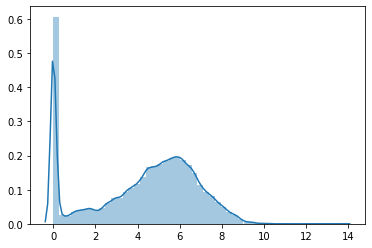

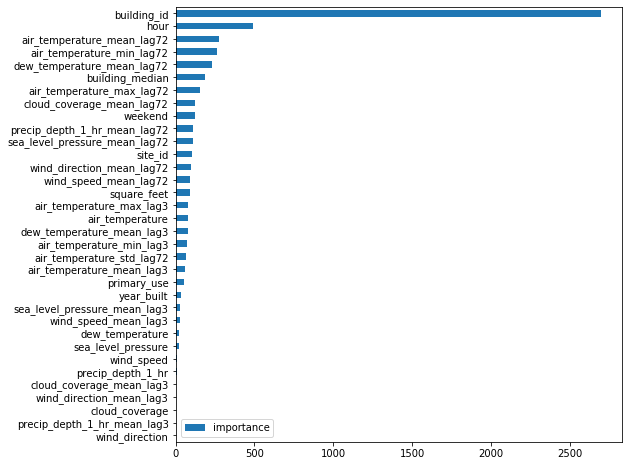

In [13]:
%%time
#meter=1

target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in categorical_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=categorical_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

#查看模型系数
#plot_feature_importance(models1[1])

target_meter 2 (2708713, 34)
cat_features [31, 32, 33]
train 2166970 valid 541743
training LGB:


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.58222	valid_1's l2: 3.17707
[40]	training's l2: 1.88262	valid_1's l2: 2.58322
[60]	training's l2: 1.68428	valid_1's l2: 2.46892
[80]	training's l2: 1.57456	valid_1's l2: 2.43412
[100]	training's l2: 1.50172	valid_1's l2: 2.43299
Early stopping, best iteration is:
[95]	training's l2: 1.5184	valid_1's l2: 2.43035
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.5184026561512334)]), 'valid_1': OrderedDict([('l2', 2.43035108616187)])})
train 2166970 valid 541743
training LGB:
Training until validation scores don't improve for 20 rounds
[20]	training's l2: 2.55942	valid_1's l2: 2.899
[40]	training's l2: 1.8362	valid_1's l2: 2.39938
[60]	training's l2: 1.63138	valid_1's l2: 2.30737
[80]	training's l2: 1.53361	valid_1's l2: 2.25958
[100]	training's l2: 1.4694	valid_1's l2: 2.22769
[120]	training's l2: 1.4192	valid_1's l2: 2.20748
[140]	training's l2: 1.38035	valid_1's

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Wall time: 6min 26s


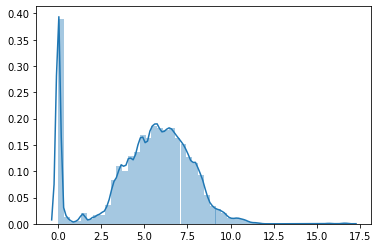

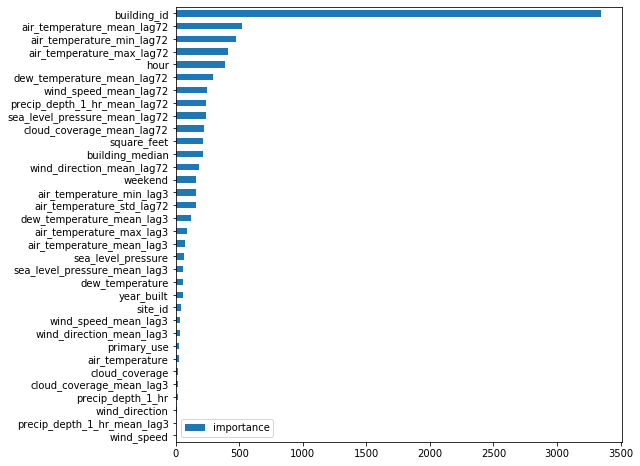

In [14]:
%%time
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in categorical_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=categorical_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

#查看模型系数
#plot_feature_importance(models2[1])

target_meter 3 (1264037, 34)
cat_features [31, 32, 33]
train 1011229 valid 252808
training LGB:


D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[20]	training's l2: 3.50195	valid_1's l2: 4.24782
[40]	training's l2: 2.48043	valid_1's l2: 3.13894
[60]	training's l2: 2.12094	valid_1's l2: 2.69839
[80]	training's l2: 1.96216	valid_1's l2: 2.51979
[100]	training's l2: 1.86694	valid_1's l2: 2.44543
[120]	training's l2: 1.79755	valid_1's l2: 2.39724
[140]	training's l2: 1.74219	valid_1's l2: 2.3527
[160]	training's l2: 1.69747	valid_1's l2: 2.33732
[180]	training's l2: 1.66232	valid_1's l2: 2.3246
[200]	training's l2: 1.63089	valid_1's l2: 2.31598
[220]	training's l2: 1.60325	valid_1's l2: 2.31238
[240]	training's l2: 1.57585	valid_1's l2: 2.31387
Early stopping, best iteration is:
[234]	training's l2: 1.58448	valid_1's l2: 2.31099
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('l2', 1.5844847271787692)]), 'valid_1': OrderedDict([('l2', 2.310991497501813)])})
train 1011229 valid 252808
training LGB:
Training until validation scores don't

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Wall time: 4min 57s


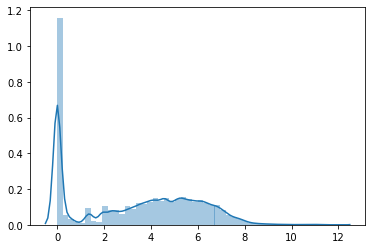

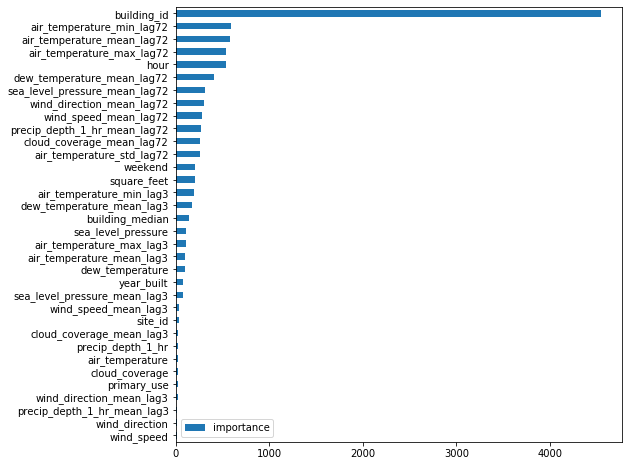

In [15]:
%%time
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in categorical_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=categorical_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
del X_train, y_train
gc.collect()

#查看模型系数
#plot_feature_importance(models3[1])

In [39]:
gc.collect()

290

In [40]:
print('loading...')
test_df = pd.read_csv('test.csv', parse_dates=['timestamp'])
test_df = reduce_mem_usage(test_df)
weather_test_df = pd.read_csv('weather_test.csv', parse_dates=['timestamp'])
weather_test_df = reduce_mem_usage(weather_test_df)
gc.collect()

print('preprocessing building...')
test_df['date'] = test_df['timestamp'].dt.date
preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = timestamp_align(weather_test_df)
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

gc.collect()

loading...
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
preprocessing building...
preprocessing weather...


315

In [41]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission = reduce_mem_usage(sample_submission)
gc.collect()

Mem. usage decreased to 198.83 Mb (68.7% reduction)


93

In [42]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    target_test_df = target_test_df[numerical_cols + categorical_cols]
    target_test_df = reduce_mem_usage(target_test_df)
    return target_test_df

def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

In [43]:
%%time
#预测meter=0
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

NameError: name 'building_meta_df' is not defined

In [44]:
%%time
#预测meter=1
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

NameError: name 'building_meta_df' is not defined

In [45]:
%%time
#预测meter=2
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

NameError: name 'building_meta_df' is not defined

In [46]:
%%time
#预测meter=3
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

NameError: name 'building_meta_df' is not defined

In [47]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

NameError: name 'y_test0' is not defined

In [ ]:
sample_submission.to_csv('submission_lgb.csv', index=False, float_format='%.4f')